In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as pe
from sklearn.metrics import ConfusionMatrixDisplay

There are 12 wells, the well N2 is one of those wells which is pretty complete, that's why it's being analyzed.

- Core facies -> facies description, code = 0 when no description and has a number when we do have some core description. Core facies from 22 to 27
- Phi H and Phi V -> porosity data  (horizontal, vertical), it's a __scalar__ and does not vary with direction, it should be the same. From a practical point of view there is a difference because of the way they are cut in the lab.
- log KV, log KH -> intrinsic permeability determined in the lab. Unlike $\phi$ need 2 measurements because it's a __tensor__ and not a scalar

## Geology
- Brent on top
- Tarbet on bottom (shoreface)

In [18]:
n2:pd.DataFrame = pd.read_csv("George.csv") # from N2.las
core_facies:dict = {
    22:"Clean sandstone",
    23:"Feldspathic sandstone",
    24:"Micacesous sandstone",
    25:"silty shale",
    26:"shale",
    27:"coal",
    0:"no label" # no label
}
n2.describe()

,DEPTH,NPHI,RHOB,SGR(=GR),COREFACIES,PHIH,PHIV,MARKERS,PHIE,SWE,VSH,POTA,LOGKH,LOGKV
count,1609.000000,1401.000000,1401.000000,1401.000000,1401.000000,422.000000,111.000000,6.000000,1400.000000,1400.000000,1401.000000,1401.000000,391.000000,111.000000
mean,3306.043878,0.216927,2.423426,61.260677,3.571021,14.927014,15.003604,4.166667,10.387643,0.730956,0.320241,0.201968,1.373251,1.018126
std,80.854316,0.088241,0.162188,26.132569,8.652216,5.510403,5.259345,3.188521,7.958618,0.317975,0.336113,0.087722,1.514431,1.520406
min,3167.000000,0.066000,1.528000,14.679000,0.000000,0.600000,1.900000,1.000000,0.000000,0.033000,0.000000,0.029000,-2.000000,-2.000000
25%,3235.800000,0.150000,2.326000,40.517000,0.000000,11.525000,11.450000,2.250000,1.965000,0.626000,0.018000,0.129000,-0.058500,-0.180500
50%,3304.200000,0.195000,2.402000,58.094000,0.000000,15.800000,15.500000,3.500000,11.630000,0.850000,0.206000,0.208000,1.842000,1.233000
75%,3376.800000,0.285000,2.557000,84.340000,0.000000,19.175000,19.150000,4.750000,16.830000,1.000000,0.525000,0.274000,2.677000,2.383500
max,3447.000000,0.589000,2.931000,131.946000,27.000000,25.500000,24.400000,10.000000,27.020000,1.000000,1.000000,0.474000,3.733000,3.412000


In [19]:
for i in n2.columns:
    print(i)

DEPTH
NPHI
RHOB
SGR(=GR)
COREFACIES
PHIH
PHIV
MARKERS
PHIE
SWE
VSH
POTA
LOGKH
LOGKV


In [20]:
pe.scatter(x=n2["DEPTH"], y = n2["NPHI"])

In [21]:
layers = n2.dropna(subset="MARKERS")[["DEPTH", "MARKERS"]]
layers

,DEPTH,MARKERS
60,3179.0,1.0
373,3231.0,10.0
481,3249.0,2.0
774,3299.0,3.0
1296,3394.0,4.0
1573,3440.0,5.0


# Create a composite document

/tmp/nix-shell-12367-0/ipykernel_12767/1861169557.py:26: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



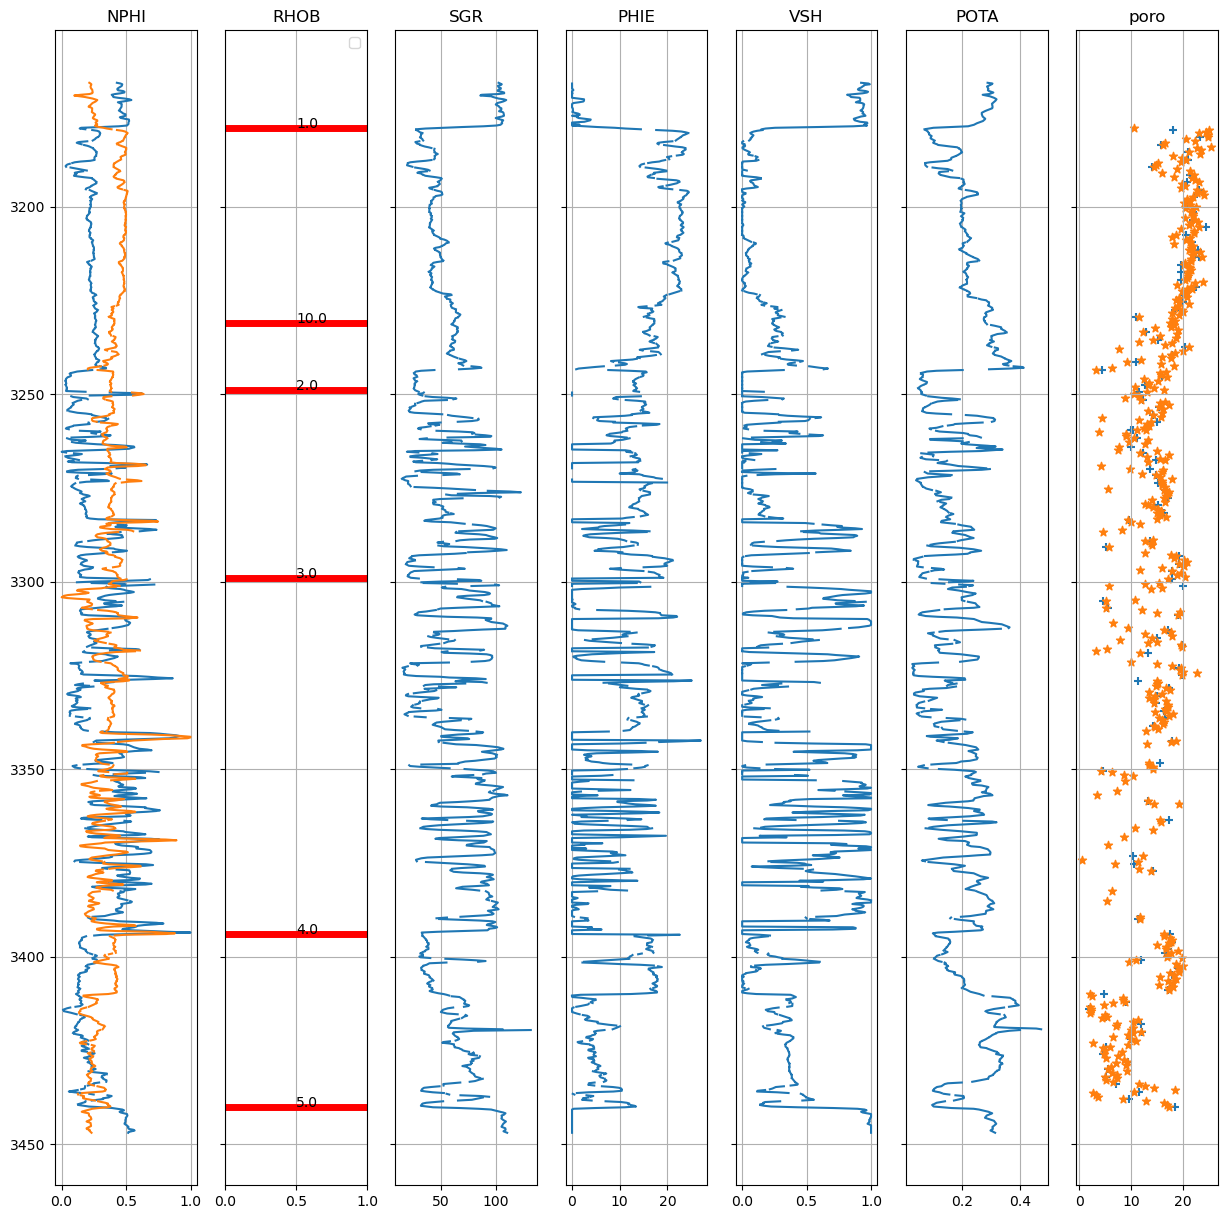

In [22]:
from sklearn.preprocessing import minmax_scale
ncols = 7
# TODO: flip vertically
fig, axs = plt.subplots(ncols=ncols, sharey=True, figsize=(15, 15))
axs[0].plot(minmax_scale(n2.NPHI), n2.DEPTH)
axs[0].plot([1-x for x in minmax_scale(n2.RHOB)], n2.DEPTH)# implement proper scale
# axs[1].bar(n2.COREFACIES, n2.DEPTH)
for depth, name in zip(layers.DEPTH, layers.MARKERS):
    axs[1].axhline(depth, c="red", lw=5, label=core_facies.get(name))
    axs[1].text(0.5, depth, name)


axs[2].plot(n2["SGR(=GR)"], n2.DEPTH) # TODO: add markers to sgr
axs[3].plot(n2["PHIE"], n2.DEPTH)
axs[4].plot(n2["VSH"], n2.DEPTH)
axs[5].plot(n2["POTA"], n2.DEPTH)

axs[6].scatter(n2.PHIV, n2.DEPTH, label="phiv", marker="+")
axs[6].scatter(n2.PHIH, n2.DEPTH, label="phih", marker="*")

titles = ["NPHI", "RHOB", "SGR", "PHIE", "VSH", "POTA", "poro"]

[axs[x].grid() for x in range(0, ncols)]
[axs[num].set_title(title) for num, title in enumerate(titles)]
[axs[x].invert_yaxis() for x in range(0, ncols)]
axs[1].legend()

## Porosity
We can see a good link between v porosity and h porosity. If it were not the case, vidamus illae res: 
- Depth shift
- Difference between rock under pressure in res and when they are measured @ atmospheric. In this case it was measured with confining pressure so it's not a problem here.
- Drying conditions in lab affecting shales in sample

### Overburden correction
We measure a few points in confinement because it's expensive. From these measuremetns we can then calculate a correction to apply from remaining samples measured without confinement. Need around 15 samples measured in confinement.

## Porosity
We can see a good link between v porosity and h porosity. If it were not the case, vidamus illae res: 
- Depth shift
- Difference between rock under pressure in res and when they are measured @ atmospheric. In this case it was measured with confining pressure so it's not a problem here.

### Overburden correction
We measure a few points in confinement because it's expensive. From these measuremetns we can then calculate a correction to apply from remaining samples measured without confinement. Need around 15 samples measured in confinement.

3245 -> channel sandstone because creates a lobe -> reservoir rock

Coal bed= large neutron value and low rhob value

Silty clays very shaly sandstone -> shale with some silt

# supervised analysis
Using 6 categories described in dictionary above.
```python
labels = n2.COREFACIES
data   = n2[[n2.columns]]
```

## QC
Want to see how our data covers our data

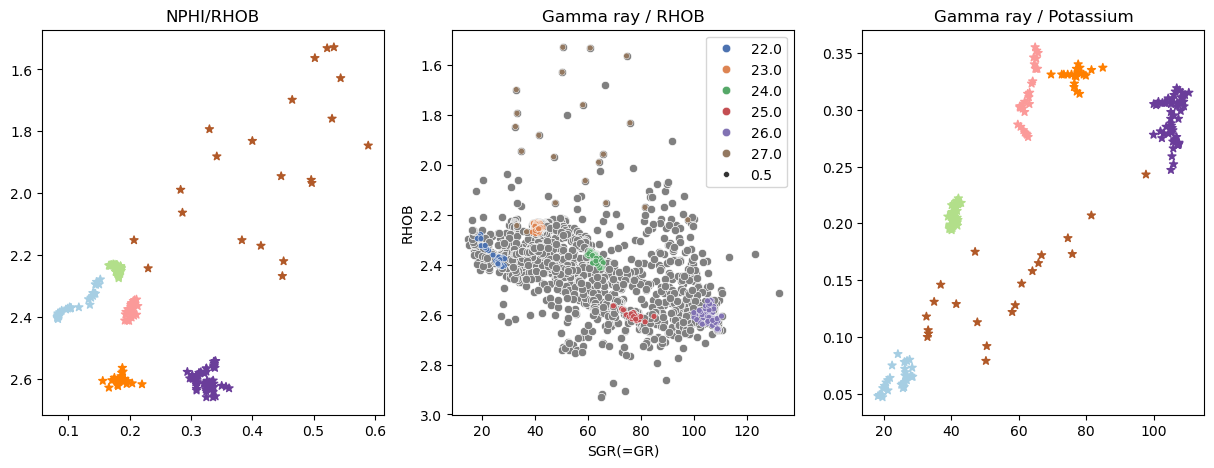

In [23]:

labelled = n2.loc[(n2.COREFACIES<=27)&(n2.COREFACIES>=22), :]

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
# NPHI / RHOB
ax[0].scatter(labelled.NPHI, labelled.RHOB, marker="*", c=labelled.COREFACIES, cmap="Paired")
# Gamma ray / rho B
#ax[1].scatter(labelled["SGR(=GR)"], labelled.RHOB, marker="*",c=labelled.COREFACIES, cmap="Paired")

sns.scatterplot(data=n2, x="SGR(=GR)", y="RHOB", ax=ax[1], c="gray")
sns.scatterplot(data=labelled, x="SGR(=GR)", y="RHOB", ax=ax[1], hue="COREFACIES", palette="deep", size=0.5)

# TODO: convert other plots to sns
ax[2].scatter(labelled["SGR(=GR)"], labelled.POTA, marker="*",c=labelled.COREFACIES, cmap="Paired")
ax[1].invert_yaxis()
ax[0].invert_yaxis()

ax[0].set_title("NPHI/RHOB")
ax[1].set_title("Gamma ray / RHOB")
ax[2].set_title("Gamma ray / Potassium")
ax[1].legend()

Good because good representation of all values and there are no anomalies

## Linear model

/tmp/nix-shell-12367-0/ipykernel_12767/1806626156.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/nix-shell-12367-0/ipykernel_12767/1806626156.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/nix-shell-12367-0/ipykernel_12767/1806626156.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

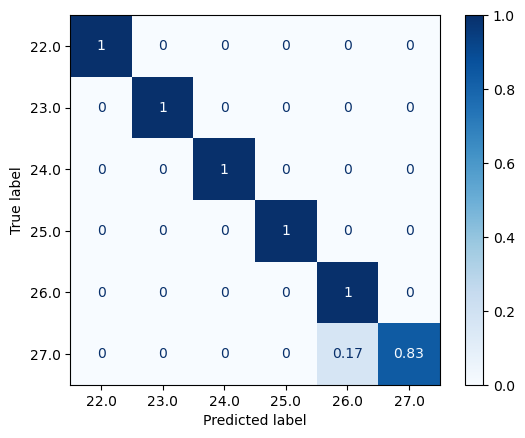

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
linear = n2.dropna(subset=logs)
logs = ["RHOB", "NPHI", "SGR(=GR)"] # data used in model
y_labels = [core_facies.get(x) for x in labelled["COREFACIES"]]
X = labelled[logs]
y = labelled["COREFACIES"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
clf.predict(X_test)

# propagate -- start
linear.loc[:, "label"] = [core_facies.get(x) for x in clf.predict(linear[logs])]
pro = clf.predict_proba(linear[logs])

for num, l in enumerate(logs):
    linear[f"prop_{l}"] = [x[num] for x in pro]
# propagate -- end
probabilities = clf.predict_proba(X_test)
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues,normalize='true')

In [44]:
linear

,DEPTH,NPHI,RHOB,SGR(=GR),COREFACIES,PHIH,PHIV,MARKERS,PHIE,SWE,VSH,POTA,LOGKH,LOGKV,label,prop_RHOB,prop_NPHI,prop_SGR(=GR)
0,3167.0,0.290,2.630,102.621,0.0,NaN,NaN,NaN,NaN,NaN,0.923,0.289,NaN,NaN,shale,6.235708e-59,7.954195e-40,3.804878e-18
1,3167.2,0.305,2.617,104.072,0.0,NaN,NaN,NaN,0.0,1.0,0.980,0.306,NaN,NaN,shale,7.649561e-62,4.934102e-42,1.039725e-19
2,3167.4,0.312,2.608,105.524,0.0,NaN,NaN,NaN,0.0,1.0,0.991,0.303,NaN,NaN,shale,4.868759e-64,1.230513e-43,8.321495e-21
3,3167.6,0.311,2.610,104.631,0.0,NaN,NaN,NaN,0.0,1.0,0.947,0.298,NaN,NaN,shale,6.357330e-63,8.068966e-43,2.883099e-20
4,3167.8,0.310,2.614,102.011,0.0,NaN,NaN,NaN,0.0,1.0,0.944,0.292,NaN,NaN,shale,8.574216e-60,1.568296e-40,9.079779e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,3446.2,0.357,2.626,109.033,26.0,NaN,NaN,NaN,0.0,1.0,1.000,0.303,NaN,NaN,shale,1.321458e-73,6.061046e-52,9.244212e-27
1605,3446.4,0.362,2.631,108.064,26.0,NaN,NaN,NaN,0.0,1.0,1.000,0.299,NaN,NaN,shale,3.950306e-73,9.045076e-52,1.033734e-26
1606,3446.6,0.350,2.623,107.094,26.0,NaN,NaN,NaN,0.0,1.0,1.000,0.305,NaN,NaN,shale,1.961970e-70,2.187860e-49,5.265487e-25
1607,3446.8,0.337,2.616,108.776,26.0,NaN,NaN,NaN,0.0,1.0,1.000,0.310,NaN,NaN,shale,7.407050e-71,2.430808e-49,8.025416e-25


## Quadratic model

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
labelled = n2.loc[(n2.COREFACIES<=27)&(n2.COREFACIES>=22), :]
all_values = n2.dropna(subset=logs)

X = labelled[logs]
y = [core_facies.get(x) for x in labelled["COREFACIES"]]

clf = QuadraticDiscriminantAnalysis()


clf.fit(X, y)


proba = clf.predict_proba(all_values[logs])
all_values["pred"] = clf.predict(all_values[logs])
all_values["proba"] = [max(val) for val in proba]
# ConfusionMatrixDisplay.from_estimator(clf, X, y, cmap=plt.cm.Blues,normalize='true')
# plt.bar(all_values.proba, all_values.DEPTH, color=all_values.pred, legend=Fa)
labelled.columns

# Electrofacies data
Use well data and not log data because we need data on most of the well. 
> Set of depth points where combination of log signature is the same.

## Supervised
- Use core data to label and propagate on other values later on

Finished electrofacies data => for each line have an associated lithology
# Petrophysics
Once we have our data, we work on petrophysics (porosity, permeability ...)

## Variogramm model
Some curve models needs to be implemented, because some values need to be continuous.
For example converting distance into pressure to determine distance from fwl from pressure.

## qc
Very important because it's the heart of Oil In Place calculation. Determined from deep resistivity and Archie law. 

# Supervised analysis
Use Bayesian, it's a very general classifier, (not finished) 
$$P(C_i/x)=\frac{p(x/C_i)\times p(C_i)}{\sum^k_{j=1}p(x/C_j)\times p(}$$
Where: 
- p(ci) is the weight or a priori probability of class Ci, can be determined manually if we know the geology well.
- P(x/Ci) -> the pdf (Probability Density Function) of the class. A simple way of getting a pdf would be to use a gaussian because it's simple to computer, creates round shaped classes. Can also use a *non parametric pdf* it's only viable if we have a large dataset, more precise because classes can be almost any shape. Can be determined linearly (variance = covariance matrix) or quadratically (p37).

In [ ]:
from sklearn.datasets import load_iris

from sklearn.naive_bayes import GaussianNB


# gamma, rhob, nphi
subset = n2.loc[(n2.COREFACIES<=27)&(n2.COREFACIES>=22), :]
# x values for prediction, y values labels
# X, y = subset[["SGR(=GR)", "RHOB", "NPHI"]], subset["COREFACIES"]
X, y = subset[["SGR(=GR)"]], [core_facies.get(x) for x in subset["COREFACIES"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

## Cross validation
Using confusion matrix

In [ ]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        gnb,
        X_test,
        y_test,
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true'
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

 # Propagate
 Now that we have trained the model, we can propagate it to the remaining anonymous points.

In [ ]:
unlabelled = n2.loc[n2.COREFACIES==0, :]
unlabelled["label"] = gnb.predict(unlabelled[logs])

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
sns.scatterplot(data=labelled, x="RHOB", y="NPHI", hue=[core_facies.get(x) for x in labelled["COREFACIES"]], ax=ax[0], palette="viridis")
sns.scatterplot(data=unlabelled, x="RHOB", y="NPHI", hue="label", ax=ax[0])

sns.scatterplot(data=labelled, x="RHOB", y="SGR(=GR)", hue=[core_facies.get(x) for x in labelled["COREFACIES"]], ax=ax[1], palette="viridis")
sns.scatterplot(data=unlabelled, x="RHOB", y="SGR(=GR)", hue="label", ax=ax[1])

ax[0].invert_xaxis()

In [ ]:
from sklearn.preprocessing import minmax_scale
ncols = 7
# TODO: flip vertically
fig, axs = plt.subplots(ncols=ncols, sharey=True, figsize=(15, 15))
axs[0].plot(minmax_scale(n2.NPHI), n2.DEPTH)
axs[0].plot([1-x for x in minmax_scale(n2.RHOB)], n2.DEPTH)# implement proper scale
# axs[1].bar(n2.COREFACIES, n2.DEPTH)
for depth, name in zip(layers.DEPTH, layers.MARKERS):
    axs[1].axhline(depth, c="red", lw=5, label=core_facies.get(name))
    axs[1].text(0.5, depth, name)


axs[2].plot(n2["SGR(=GR)"], n2.DEPTH) # TODO: add markers to sgr
axs[3].plot(n2["PHIE"], n2.DEPTH)
axs[4].plot(n2["VSH"], n2.DEPTH)
axs[5].plot(n2["POTA"], n2.DEPTH)


axs[6].scatter(n2.PHIV, n2.DEPTH, label="phiv", marker="+")
axs[6].scatter(n2.PHIH, n2.DEPTH, label="phih", marker="*")
# sns.scatterplot(data=unlabelled, x="RHOB", y="DEPTH", hue="label", ax=ax[6])

titles = ["NPHI", "RHOB", "SGR", "PHIE", "VSH", "POTA", "poro"]

[axs[x].grid() for x in range(0, ncols)]
[axs[num].set_title(title) for num, title in enumerate(titles)]
[axs[x].invert_yaxis() for x in range(0, ncols)]
axs[1].legend()

# Classifiers

## Quadratic
$$C_i\approx N(m_i, \Sigma_i)$$
## Linear
$$C_i=N(m_i, \Sigma)$$
$$\Sigma=\frac{1}{n}\times \Sigma^k_{i=1} n_i\Sigma_i$$
Where: 
- $n_i$ = number of learning points dans $C_i$
- n = $\Sigma^r_{i=1}n_i$
- $\Sigma_i$ matrice de variance / covariance de la classe i
- $m_i$ = average for a specific class, for us it will be a vector of 3 values because we have 3 classes

In [ ]:
# variance covariance matrix
import numpy as np


Should find that although the classification seems correct, in practice coal is often misclassified

# Non supervised
KNN pdf estimator. The idea is to compute the density in any feature in *feature space*. 

## Kernel smooth
Using a kernel to smooth the histogram. On the topic of histogram, it's important to choose the correct number of bins. If it's too large then we cannot see much in data.

## PDF
Create a surface that covers the points, a bit like a surface regression but it can be in may dimensions. To find the peaks we use a algorithm that visits the points and creates a 2D diagram using a tucker diagram. 
**kittler pattern recognition**

### from sklearn.neighbors import KernelDensity
from scipy.signal import savgol_filter

X = savgol_filter(X, window_length=400, polyorder=2, mode="nearest") 
kde = KernelDensity(kernel='epanechnikov').fit(X)
sns.lineplot(kde.score_samples(X))

In [ ]:
from sklearn.neighbors import KernelDensity
from scipy.signal import savgol_filter
from skimage.filters import threshold_minimum
subset = n2.dropna(subset=logs)

X = np.array(subset[logs])
# X = savgol_filter(X, window_length=10, polyorder=5, mode="nearest") 
# kde = KernelDensity(kernel='epanechnikov', bandwidth=0.75).fit(X)
# sns.lineplot(kde.score_samples(X))
# threshold_minimum(X)

In [ ]:
labelled

In [ ]:

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

fig, ax = plt.subplots(ncols=2)
subset = n2.dropna(subset=logs)
t1, t2 = 1, 1.2
subset["mysum"] = NormalizeData(subset["RHOB"]) * NormalizeData(subset["NPHI"]) * NormalizeData(subset["SGR(=GR)"])
sns.displot(data=subset, x="mysum", bins=50, ax=ax[0])

subset["hue"] = (subset.mysum>t1)&(subset.mysum<t2)

sns.scatterplot(data=subset, x="NPHI", y="RHOB", ax=ax[1], hue="hue")

In [ ]:
sns.displot(data=n2, x="RHOB", kde=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.cluster import KMeans

knn = KMeans(5)


subset = n2.dropna(subset=logs)
X = subset[logs]
knn.fit(X)
subset["predicted"] = knn.predict(subset[logs])

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
sns.scatterplot(data=subset, x="RHOB", y="NPHI", hue="predicted", ax=ax[0])
sns.scatterplot(data=subset, x="RHOB", y="SGR(=GR)", hue="predicted", ax=ax[1])
# probabilities = knn.predict_proba(X)
sns.scatterplot(data=subset, x="", y=""

Non supervised is a better predictor for lower brent than supervised, because the probability is stronger.

# Creating k-$\phi$ model

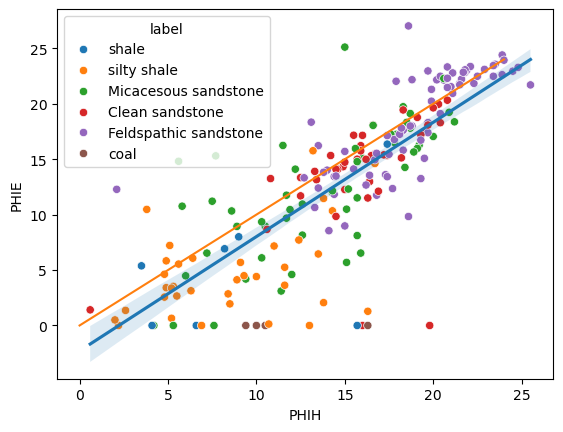

In [56]:
fig, ax = plt.subplots()
sns.scatterplot(data=linear, x="PHIH", y="PHIE", hue="label", ax=ax)
sns.regplot(data=linear, x="PHIH", y="PHIE", scatter=False, ax=ax) # bad idea, can introduce mistakes
ax.plot(range(0, 25), range(0, 25)) # creating bissectrice

/tmp/nix-shell-12367-0/ipykernel_12767/3296643280.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



shale => 0.5970932797457584x + -3.4636394211578634
silty shale => 0.08491907907642551x + -0.1492806881465527
Micacesous sandstone => 0.49948706602725806x + -3.739387788688126
Clean sandstone => 1.1216318554142233x + -1.3557995919193857
Feldspathic sandstone => 1.2127378251358165x + -11.58373160141856
coal => 0.90966343272752x + -7.512665225128711


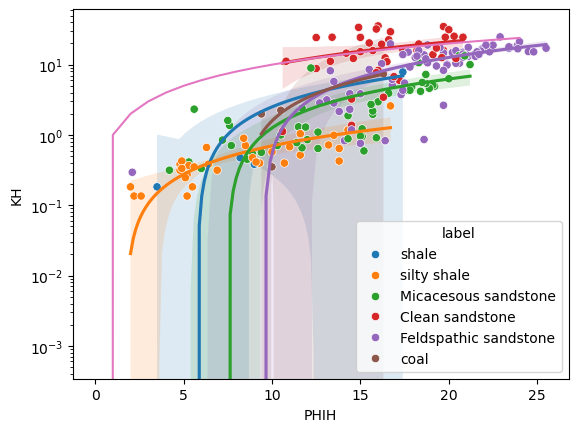

In [95]:
fig, ax = plt.subplots()
linear["KH"] = np.exp(linear["LOGKH"])
from sklearn.linear_model import LinearRegression

for i in linear.label.unique():
    data = linear.loc[linear.label == i].dropna(subset=["PHIH", "KH"])
    sns.regplot(data=data, x="PHIH", y="KH", scatter=False, ax=ax)
    
    X = data["PHIH"].values.reshape(-1, 1)
    y = data["KH"].values
    lr = LinearRegression().fit(X, y)
    print(f"{i} => {lr.coef_[0]}x + {lr.intercept_}")
    
ax.plot(range(0, 25), range(0, 25)) # creating bissectrice
sns.scatterplot(data=linear, x="PHIH", y="KH", hue="label", ax=ax)
ax.set_yscale("log")